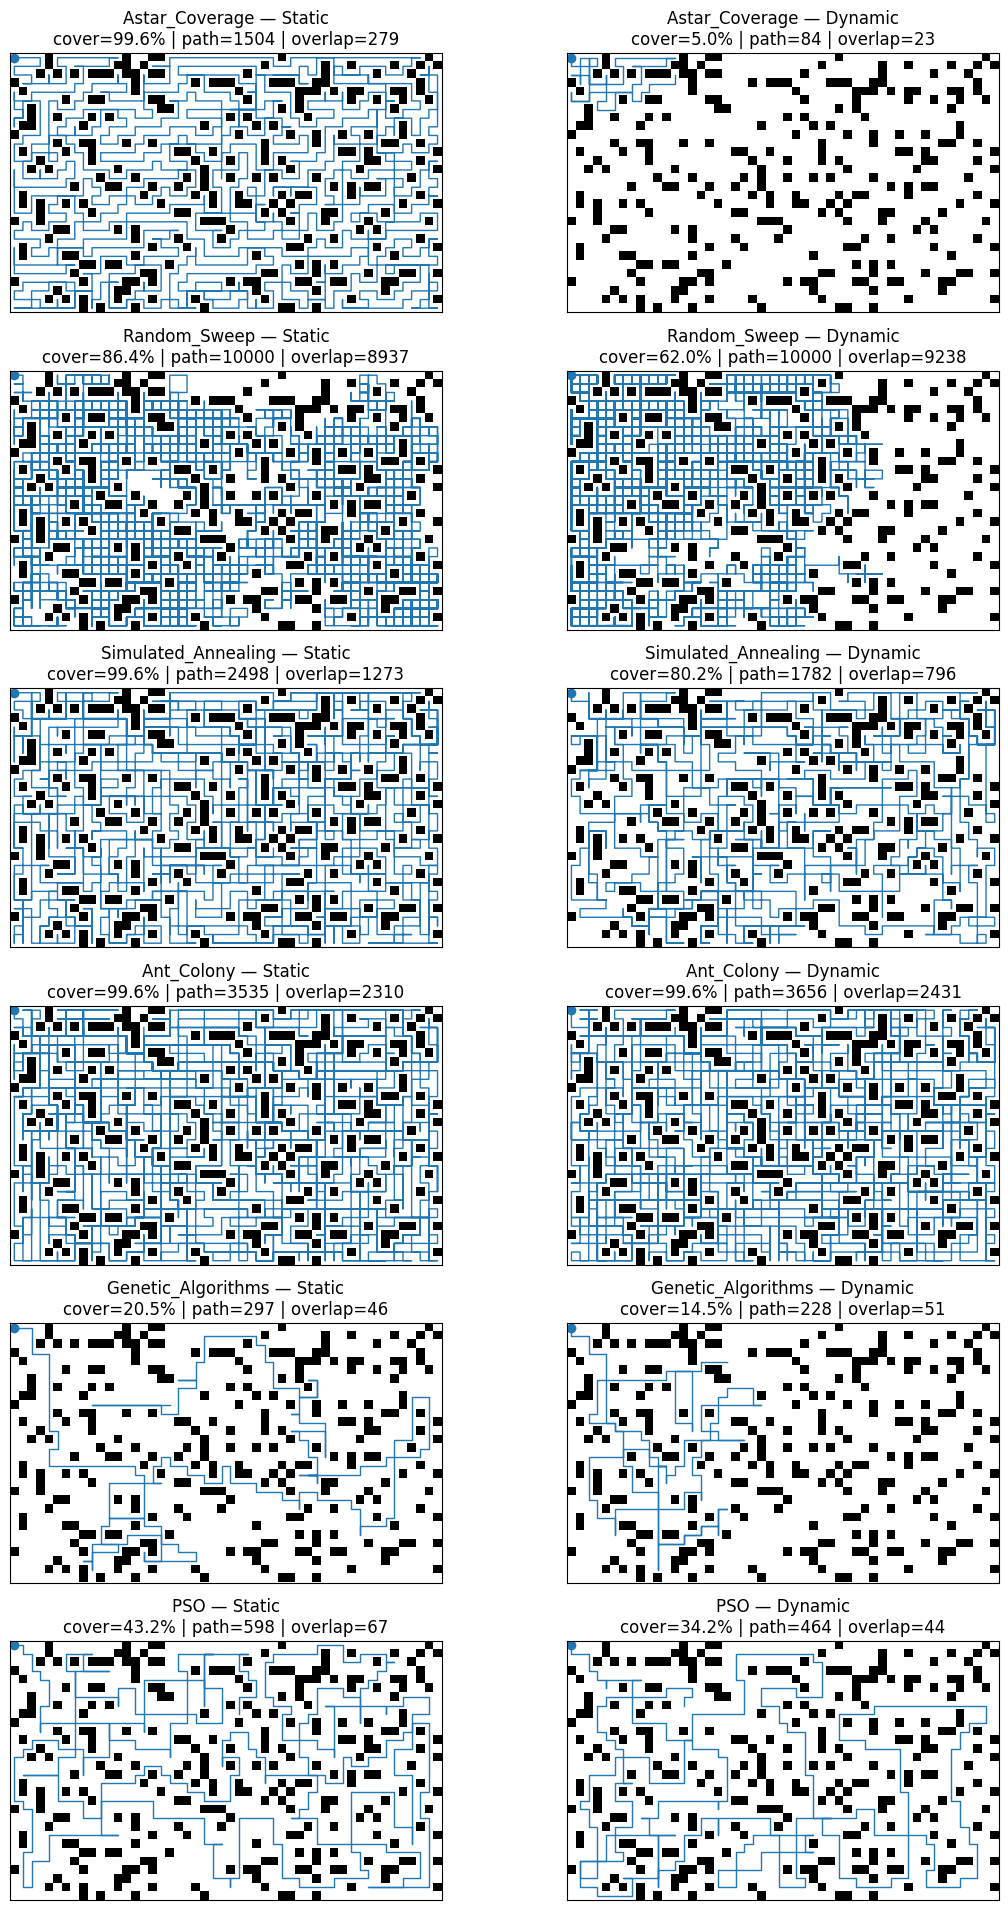


=== Static Results ===
Astar_Coverage         | Coverage= 99.59% | Path= 1504 | Overlap=  279 | Time= 0.511s | Energy=  1504 | Full=False
Random_Sweep           | Coverage= 86.43% | Path=10000 | Overlap= 8937 | Time= 0.031s | Energy= 10000 | Full=False
Simulated_Annealing    | Coverage= 99.59% | Path= 2498 | Overlap= 1273 | Time= 0.296s | Energy=  2498 | Full=False
Ant_Colony             | Coverage= 99.59% | Path= 3535 | Overlap= 2310 | Time= 5.031s | Energy=  3535 | Full=False
Genetic_Algorithms     | Coverage= 20.47% | Path=  297 | Overlap=   46 | Time= 5.070s | Energy=   297 | Full=False
PSO                    | Coverage= 43.22% | Path=  598 | Overlap=   67 | Time= 5.022s | Energy=   598 | Full=False

=== Dynamic Results ===
Astar_Coverage         | Coverage=  5.04% | Path=   84 | Overlap=   23 | Time= 0.034s | Energy=    84 | Full=False
Random_Sweep           | Coverage= 61.98% | Path=10000 | Overlap= 9238 | Time= 0.159s | Energy= 10000 | Full=False
Simulated_Annealing    | Covera

In [ ]:
import math
import random
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Set, Dict
import heapq
# For Grid Representation
import numpy as np
import matplotlib.pyplot as plt

Coord = Tuple[int, int]

# ----------GridWorld Class (The 2D Environment)----------

@dataclass
class GridWorld:
  width: int
  height: int
  ObstacleRatio: float = 0.15 # percentage of cells randomly set as static objects
  seed: int = 0
  DynamicObstacles: int = 0 # Number of moving obstacles
  DynamicMove_Prob: float = 0.2 # Probability that the object moves
  grid: np.ndarray = field(init=False)
  DynamicPositions: List[Coord] = field(default_factory=list) # List of Coordinates for dynamic obstacles

  # Creating Random Static Obstacles
  def __post_init__(self):
    RNG = random.Random(self.seed)
    self.grid = np.zeros((self.height, self.width), dtype=np.uint8)
    # Static obstacles
    NumberOf_Obstacles = int(self.width * self.height * self.ObstacleRatio)
    placed = 0
    while placed < NumberOf_Obstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0: # free
        self.grid[r, c] = 1  # static obstacle
        placed += 1

    self.grid[0, 0] = 0 # Start cell is always free

    # Dynamic obstacles
    self.DynamicPositions = []
    while len(self.DynamicPositions) < self.DynamicObstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0 and (r, c) not in self.DynamicPositions and (r, c) != (0,0):
        self.DynamicPositions.append((r,c))


  # --------Helper methods-------


  # Check if Coordinate is inside the grid
  def InBounds(self, p: Coord) -> bool:
    r, c = p
    return 0 <= r < self.height and 0 <= c < self.width

  # Checks if a cell is not an obstacle (dynamic or otherwise)
  def IsFree(self, p: Coord) -> bool:
    r, c = p
    if not self.InBounds(p):
      return False
    if self.grid[r, c] == 1:
      return False
    if p in self.DynamicPositions:
      return False
    return True

  # Returns the 4-connected neighbours (up, down left, right)
  def neighbors4(self, p: Coord) -> List[Coord]:
    r, c = p
    neighbor = [(r+1, c), (r-1, c), (r, c+1), (r, c-1)]
    return [q for q in neighbor if self.InBounds(q)]


  # Moves each dynamic obstacle randomly to an adjacent free cell with DynamicMove_Prob
  def StepForDynamic(self, RNG: random.Random):
    # each dynamic obstacle randomly moves to a free 4-neighbor with some probability
    NewPositions = []
    occupied = set(self.DynamicPositions)
    for position in self.DynamicPositions:
      if RNG.random() < self.DynamicMove_Prob:
        candidates = [q for q in self.neighbors4(position) if self.grid[q] == 0 and q not in occupied]
        if candidates:
          position = RNG.choice(candidates)
      NewPositions.append(position)
    self.DynamicPositions = NewPositions


# --------- UAV Agent & Metrics -------------

# Represents the UAV
# Each move costs MoveCost Energy, and stops when BatteryCapacity is reached
@dataclass
class Agent:
  start: Coord = (0, 0)
  BatteryCapacity: int = 10_000 # Amount of "Energy units"
  MoveCost: int = 1
  path: List[Coord] = field(default_factory=lambda: [(0,0)])
  EnergyUsed: int = 0
# Returns the current positions
  def at(self) -> Coord:
    return self.path[-1]

# Checks if the agent still has enegry
  def CanMove(self) -> bool:
    return (self.EnergyUsed + self.MoveCost) <= self.BatteryCapacity

# Moves the UAV to the next cell, then updates the path and energy used
  def MoveTo(self, p:Coord):
    self.path.append(p)
    self.EnergyUsed += self.MoveCost

# Holds the performance data for a single simulation
@dataclass
class RunMetrics:
  CoveragePercentage: float # CoveragePercentage
  PathLength: int # Path Length
  OverlapCount: int # Overlap Count
  ExecutionTime: float # Execution Time
  EnergyUsed: int # Energy Used
  ReachedAll: bool # Didthe agent cover all reachable cells


# ----------- Utilities -------------

def manhattan(a: Coord, b: Coord) -> int:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


# Part of Astar search, it's job is to rebuild the path from the start cell to the goal cell (lists path from start cell to goal cell)
def Rebuild_Path(From: Dict[Coord, Coord], goal: Coord) -> List[Coord]:
    current = goal
    rev = [current]
    while current in From:
        current = From[current]
        rev.append(current)
    rev.reverse()
    return rev


def Astar(grid: GridWorld, start: Coord, goal: Coord) -> Optional[List[Coord]]:
    if not grid.IsFree(start) or not grid.IsFree(goal):
        return None
    openh = []
    heapq.heappush(openh, (0 + manhattan(start, goal), 0, start))
    From: Dict[Coord, Coord] = {}
    g = {start: 0}
    visited = set()
    while openh:
        f, cost, current = heapq.heappop(openh)
        if current == goal:
            return Rebuild_Path(From, current)
        if current in visited:
            continue
        visited.add(current)
        for nb in grid.neighbors4(current):
            if not grid.IsFree(nb):
                continue
            newg = cost + 1
            if nb not in g or newg < g[nb]:
                g[nb] = newg
                From[nb] = current
                heapq.heappush(openh, (newg + manhattan(nb, goal), newg, nb))
    return None


# ----------------------- Algorithms -------------------------

def Astar_Coverage(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()]) # keeps track of all visited cells
    overlap = 0 # counts revisited cells
    t0 = time.perf_counter() # record start time

    # Builds a mask for all free celss
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum()) # Total number of free cells

# Main loop: Keep looping until the agent still has battery, until the step count isn't exceeded and time doesn't run out
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic:
            world.StepForDynamic(RNG)

      # Find nearest unvisited target
        current = agent.at()
        targets: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    targets.append((manhattan(current, p), p))
        if not targets:
            break
        targets.sort(key=lambda x: x[0])

        path = None
        for _, goal in targets[:500]:  # try nearest few
            path = Astar(world, current, goal)
            if path:
                break

        if not path:  # no reachable unvisited cell (blocked by obstacles/dynamics)
            break

        # Follow the path step-by-step
        for nxt in path[1:]:
            if dynamic and not world.IsFree(nxt):
                # Need to replan from current position
                break
            if not agent.CanMove():
                break # out of battery
            Prev_len = len(visited)
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1

    t1 = time.perf_counter()
    covered = len(visited)
    CoveragePercentage = 100.0 * covered / max(1, Total_Free)
    return RunMetrics(
        CoveragePercentage=CoveragePercentage,
        PathLength=len(agent.path)-1,
        OverlapCount=overlap,
        ExecutionTime=t1 - t0,
        EnergyUsed=agent.EnergyUsed,
        ReachedAll=(CoveragePercentage >= 99.9)
    )


def RandomSweep(world: GridWorld, agent: Agent, seed: int = 0,
                 dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Free_Mask = (world.grid == 0)
    Total_Free = int(Free_Mask.sum())

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic:
            world.StepForDynamic(RNG)
        current = agent.at()
        moves = [p for p in world.neighbors4(current) if world.IsFree(p)]
        if not moves:
            break
        nxt = RNG.choice(moves)
        if nxt in visited:
            overlap += 1
        agent.MoveTo(nxt)
        visited.add(nxt)
        steps += 1
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(
        CoveragePercentage=CoveragePercentage,
        PathLength=len(agent.path)-1,
        OverlapCount=overlap,
        ExecutionTime=t1 - t0,
        EnergyUsed=agent.EnergyUsed,
        ReachedAll=(CoveragePercentage >= 99.9)
    )


# Simulated Annealing

def SimulatedAnnealing(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()]) #  set of already visited cells
    overlap = 0 # counts how many times agent revisits the cell
    t0 = time.perf_counter() # measuring execution time
    # Builds a mask of free cells
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

    steps = 0
    T0, T_min, cooling = 5.0, 0.1, 0.995  # temperature parameters
    T = T0

    while agent.CanMove() and steps < Max_steps: # loop until energy runs out or time expires
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic:
            world.StepForDynamic(RNG)

        current = agent.at()
        # gather candidate unvisited frontiers (nearest first)
        candidates: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    candidates.append((abs(r-current[0]) + abs(c-current[1]), p))

        # if not unvisited cells remain stop
        if not candidates:
            break
        candidates.sort(key=lambda x: x[0])
        candidates = candidates[:200]  # limit scope

        # SA choice: softmin over distance with temperature
        dists = [max(1, d) for d, _ in candidates]
        weights = [math.exp(-d / max(T, 1e-6)) for d in dists] # Computes Boltzmann distribution
        s = sum(weights)
        probs = [w / s for w in weights]
        # Sample one goal according to those probabilities
        rnum = RNG.random()
        cum = 0.0
        goal = candidates[0][1]
        for (d, p), pr in zip(candidates, probs):
            cum += pr
            if rnum <= cum:
                goal = p
                break


# Uses A* to traverse to the goal
        path = Astar(world, current, goal)
        # if failed, try a few other picks
        tries = 0
        while path is None and tries < 10 and candidates:
            goal = candidates[min(len(candidates)-1, RNG.randrange(len(candidates)))][1]
            path = Astar(world, current, goal)
            tries += 1
        if path is None:
            break

# Path following
        for nxt in path[1:]:
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1

        T = max(T_min, T * cooling) # reduces temperature

# Returning Performance metrics
    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, (CoveragePercentage >= 99.9))


# Ant Colony Optimization

def AntColony(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:

  # Tracks visited cells, overlap count, and a start timer
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

# Computes which cells are free
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

    pher = np.full_like(world.grid, 1.0, dtype=float)
    rho = 0.02     # evaporation
    alpha = 1.0    # pheromone weight
    beta = 2.0     # heuristic (1/distance) weight
    reward = 5.0   # deposit for newly covered cells

# Run until battery, step cap, or 5 second time limit is exceeded
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic:
            world.StepForDynamic(RNG)

        current = agent.at()
        # building candidate frontiers
        cand: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    cand.append((abs(r-current[0]) + abs(c-current[1]), p))
        if not cand:
            break
        cand.sort(key=lambda x: x[0])
        cand = cand[:200]
        numer = []
        for d, p in cand:
            d = max(1, d)
            tau = pher[p]
            eta = 1.0 / d
            numer.append((tau ** alpha) * (eta ** beta))
        s = sum(numer)

        # If all scores are zero pick the nearest, otherwise sample a goal proportional to its hueristic score
        if s == 0:
            goal = cand[0][1]
        else:
            rnum = RNG.random()
            cum = 0.0
            goal = cand[0][1]
            for (d, p), val in zip(cand, numer):
                cum += val / s
                if rnum <= cum:
                    goal = p
                    break

# Return to the chosen goal using Astar
        path = Astar(world, current, goal)
        tries = 0
        while path is None and tries < 10 and cand:
            goal = cand[min(len(cand)-1, RNG.randrange(len(cand)))][1]
            path = Astar(world, current, goal)
            tries += 1
        if path is None:
            # evaporate and continue
            pher *= (1.0 - rho)
            continue

# Execute the path & count new average
        newly = 0
        for nxt in path[1:]:
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            else:
                newly += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1

        # pheromone update
        pher *= (1.0 - rho)
        if newly > 0:
            pher[goal] += reward * newly

# Computing final metrics
    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, (CoveragePercentage >= 99.9))


# Genetic Algorithm

def GeneticAlgorithm(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:

  # Setup
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

# Marks all free cells
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

# Finds unvisited free cells
    def frontier_list(cur: Coord) -> List[Coord]:
        L: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    L.append((abs(r-cur[0]) + abs(c-cur[1]), p))
        L.sort(key=lambda x: x[0])
        return [p for _, p in L[:300]]

   # GA Parameters
    pop_size = 20
    seq_len = 5
    cx_rate = 0.7
    mut_rate = 0.3
    gens = 12


# UAV moves until its of energy, times out (5s) or step count is reached
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic:
            world.StepForDynamic(RNG)

        cur = agent.at()
        fr = frontier_list(cur)
        if not fr:
            break

# creates a random sequence of 5 candidate goals
        def random_seq():
            return [fr[RNG.randrange(len(fr))] for _ in range(seq_len)]

# For each sequence it uses Astar to estimate the path length to each goal
        def fitness(seq: List[Coord]) -> float:
            pos = cur
            length = 0
            gain = 0
            for g in seq:
                path = Astar(world, pos, g)
                if path is None:
                    length += 1_000_000
                    continue
                length += len(path) - 1
                # estimate newly visited reward (heuristic)
                gain += 1.0 if g not in visited else 0.0
                pos = g
            # lower length and higher gain is better
            return length - 50.0 * gain

# GA evolution
        pop = [random_seq() for _ in range(pop_size)]
        for _ in range(gens):
            scores = [(fitness(ind), ind) for ind in pop]
            scores.sort(key=lambda x: x[0])
            elite = [ind for _, ind in scores[:max(2, pop_size // 5)]]
            new_pop = elite[:]
            while len(new_pop) < pop_size:
                if RNG.random() < cx_rate:
                    a = RNG.choice(elite)
                    b = RNG.choice(pop)
                    cut = RNG.randrange(1, seq_len)
                    child = a[:cut] + b[cut:]
                else:
                    child = RNG.choice(pop)[:]
                if RNG.random() < mut_rate:
                    idx = RNG.randrange(seq_len)
                    child[idx] = fr[RNG.randrange(len(fr))]
                new_pop.append(child)
            pop = new_pop

        # takes the best and execute its first waypoint
        best_seq = min(pop, key=fitness)
        goal = best_seq[0]
        path = Astar(world, cur, goal)
        if path is None:
            continue

       # Move UAV along the path
        for nxt in path[1:]:
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1

# Return Metrics
    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, (CoveragePercentage >= 99.9))


# Particle Swarm Optimisation

def PSO(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:

  # Setup
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()


# Marks static free cells
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

# Builds list of of unvisted free cells
    def frontier(cur: Coord) -> List[Coord]:
        L: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    L.append((abs(r-cur[0]) + abs(c-cur[1]), p))
        L.sort(key=lambda x: x[0])
        return [p for _, p in L[:300]]

# Fitness function: If unreachable it gets a penalty, bonus for being in a locally unvisited neighbourhood
    def fitness(cur: Coord, goal: Coord) -> float:
        path = Astar(world, cur, goal)
        if path is None:
            return 1e9
        # prefer shorter route and goals in less-visited areas
        r, c = goal
        unv = 0
        for rr in range(max(0, r-1), min(world.height, r+2)):
            for cc in range(max(0, c-1), min(world.width, c+2)):
                if Free_Mask[rr, cc] and (rr, cc) not in visited:
                    unv += 1
        return (len(path) - 1) - 3.0 * unv

# Stops when out of energy, over the step cap, or past the 5 second limit
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic:
            world.StepForDynamic(RNG)

# Initialise the Swarm
        cur = agent.at()
        F = frontier(cur)
        if not F:
            break
        swarm_size = min(25, max(5, len(F)//8))
        particles = [F[RNG.randrange(len(F))] for _ in range(swarm_size)]
        pbest = particles[:]
        pbest_fit = [fitness(cur, g) for g in pbest]
        gbest_idx = min(range(swarm_size), key=lambda i: pbest_fit[i])
        gbest = pbest[gbest_idx]


# After moving each particle, recompute fitness and update the personal best
        iters = 10
        for _ in range(iters):
            for i in range(swarm_size):
                # "velocity" proxy: jitter toward gbest by choosing a nearby frontier
                if RNG.random() < 0.6:
                    # pick among K nearest to gbest
                    gr, gc = gbest
                    neighs = sorted(F, key=lambda p: abs(p[0]-gr) + abs(p[1]-gc))[:20]
                    particles[i] = RNG.choice(neighs)
                else:
                    particles[i] = F[RNG.randrange(len(F))]
                fit = fitness(cur, particles[i])
                if fit < pbest_fit[i]:
                    pbest[i] = particles[i]
                    pbest_fit[i] = fit
            gbest_idx = min(range(swarm_size), key=lambda j: pbest_fit[j])
            gbest = pbest[gbest_idx]

# Execute the best found goal using Astar
        goal = gbest
        path = Astar(world, cur, goal)
        if path is None:
            continue
        for nxt in path[1:]:
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1

# Computing metrics
    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, (CoveragePercentage >= 99.9))



# Function to visualise dynamic and static environments for each algorithm

def visualize_all(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20,
                  seed=7):
    world_base = GridWorld(width=width, height=height,
                           ObstacleRatio=ObstacleRatio,
                           seed=seed,
                           DynamicObstacles=DynamicObstacles,
                           DynamicMove_Prob=0.25)

# Algorithms

    Algs = {
        "Astar_Coverage": Astar_Coverage,
        "Random_Sweep": RandomSweep,
        "Simulated_Annealing": SimulatedAnnealing,
        "Ant_Colony": AntColony,
        "Genetic_Algorithms": GeneticAlgorithm,
        "PSO": PSO,
    }

    alg_names = list(Algs.keys())
    n_algs = len(alg_names)

    fig, axes = plt.subplots(n_algs, 2, figsize=(12, 3.2 * n_algs))
    if n_algs == 1:
        axes = np.array([axes])  # ensure 2D indexing

    results_static: Dict[str, RunMetrics] = {}
    results_dynamic: Dict[str, RunMetrics] = {}

    for i, (name, fn) in enumerate(Algs.items()):

        # ---- Static run ----
        agent_s = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        world_s = GridWorld(width=world_base.width, height=world_base.height,
                            ObstacleRatio=0.0, seed=seed,
                            DynamicObstacles=0,
                            DynamicMove_Prob=world_base.DynamicMove_Prob)
        world_s.grid = world_base.grid.copy()
        world_s.DynamicPositions = []

        met_s = fn(world_s, agent_s, seed=seed, dynamic=False)
        results_static[name] = met_s

        ax_s = axes[i, 0]
        img_s = np.where(world_s.grid == 1, 0.2, 1.0)
        ax_s.imshow(img_s, cmap="gray", origin="upper")
        ys = [p[0] for p in agent_s.path]
        xs = [p[1] for p in agent_s.path]
        ax_s.plot(xs, ys, linewidth=1.0)
        ax_s.scatter([agent_s.path[0][1]], [agent_s.path[0][0]], marker="o")
        ax_s.set_title(f"{name} — Static\n"
                       f"cover={met_s.CoveragePercentage:.1f}% | path={met_s.PathLength} | overlap={met_s.OverlapCount}")
        ax_s.set_xticks([]); ax_s.set_yticks([])

        # ---- Dynamic run ----
        agent_d = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        world_d = GridWorld(width=world_base.width, height=world_base.height,
                            ObstacleRatio=0.0, seed=seed,
                            DynamicObstacles=world_base.DynamicObstacles,
                            DynamicMove_Prob=world_base.DynamicMove_Prob)
        world_d.grid = world_base.grid.copy()
        world_d.DynamicPositions = list(world_base.DynamicPositions)

        met_d = fn(world_d, agent_d, seed=seed, dynamic=True)
        results_dynamic[name] = met_d

        ax_d = axes[i, 1]
        img_d = np.where(world_d.grid == 1, 0.2, 1.0)
        ax_d.imshow(img_d, cmap="gray", origin="upper")
        yd = [p[0] for p in agent_d.path]
        xd = [p[1] for p in agent_d.path]
        ax_d.plot(xd, yd, linewidth=1.0)
        ax_d.scatter([agent_d.path[0][1]], [agent_d.path[0][0]], marker="o")
        ax_d.set_title(f"{name} — Dynamic\n"
                       f"cover={met_d.CoveragePercentage:.1f}% | path={met_d.PathLength} | overlap={met_d.OverlapCount}")
        ax_d.set_xticks([]); ax_d.set_yticks([])

    plt.tight_layout()
    plt.show()

    # Print summary tables
    print("\n=== Static Results ===")
    for k, m in results_static.items():
        print(f"{k:22s} | Coverage={m.CoveragePercentage:6.2f}% | "
              f"Path={m.PathLength:5d} | Overlap={m.OverlapCount:5d} | "
              f"Time={m.ExecutionTime:6.3f}s | Energy={m.EnergyUsed:6d} | "
              f"Full={m.ReachedAll}")

    print("\n=== Dynamic Results ===")
    for k, m in results_dynamic.items():
        print(f"{k:22s} | Coverage={m.CoveragePercentage:6.2f}% | "
              f"Path={m.PathLength:5d} | Overlap={m.OverlapCount:5d} | "
              f"Time={m.ExecutionTime:6.3f}s | Energy={m.EnergyUsed:6d} | "
              f"Full={m.ReachedAll}")


if __name__ == "__main__":
    visualize_all(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20, seed=7)

